In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib inline

import pandas as pd

import json
import glob
import os

In [2]:
data = {}

for path in glob.glob(os.path.expanduser("/amd.home/home/i11/zeitz/ma/data/results/paper/strong_scaling/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [3]:
algo_name_mapping = {
    'synchronous local moving with map equation': 'Distr. MapEq',
    'synchronous local moving with modularity': 'Distr. Modularity'
}

frames['algorithm_run'].replace({ 'algorithm': algo_name_mapping }, inplace=True)

frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['switch_to_seq'].map({ False: '', True: ' w. Seq.', np.NaN: '' })

In [4]:
frames['algorithm_run']['runtime'] = (frames['algorithm_run']['done_ts'] - frames['algorithm_run']['start_ts']) / 1000000.0
distributed_algo_runs = frames['algorithm_run'][pd.isnull(frames['algorithm_run'].distributed_algorithm_run_id)]

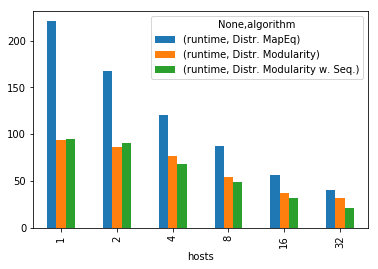

In [5]:
distributed_algo_runs \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['hosts', 'algorithm'])['runtime'].mean().to_frame().unstack().plot.bar()